In [2]:
def CountDown(n):
    while n > 0:
        n -= 1

n = 100000000  
%time CountDown(n)


CPU times: total: 3.58 s
Wall time: 4.63 s


`%time` 的CPU times 和 Wall time:
1. Wall clock time measures how much time has passed, as if you were looking at the clock on your wall. 
2. CPU time is how many seconds the CPU was busy.


`%time` 等同于linux中的`time`:
```shell
$ time echo 'o'
o

real    0m0.016s
user    0m0.000s
sys     0m0.000s
```

1. real: the wall clock time.
2. user: the process CPU time.
3. sys: the operating system CPU time due to system calls from the process.



我们想要用多线程来加速，比如下面这几行操作，结果发现，速度没有得到提升。

In [3]:
from threading import Thread

n = 100000000

t1 = Thread(target=CountDown, args=[n // 2])
t2 = Thread(target=CountDown, args=[n // 2])
t1.start()
t2.start()
t1.join()
t2.join()


# GIL Global Interpreter Lock

GIL，是最流行的 Python 解释器 CPython 中的一个技术术语。它的意思是全局解释器锁，本质上是类似操作系统的互斥锁Mutex。每一个 Python 线程，在 CPython 解释器中执行时，都会先锁住自己的线程，阻止别的线程执行。

当然，CPython 会做一些小把戏，轮流执行 Python 线程。这样一来，用户看到的就是“伪并行”——Python 线程在交错执行，来模拟真正并行的线程。

那么，为什么 CPython 需要 GIL 呢？这其实和 CPython 的实现有关。

CPython使用引用计数来管理内存，所以Python脚本中创建的实例，都会有一个引用计数，来记录有多少个指针指向它。当引用计数是0时，则会自动释放内存。

In [7]:
import sys

a = []
b = a
sys.getrefcount(a)

3

上面的例子中，a 的引用计数是 3，因为有 a、b 和作为参数传递的 `getrefcount` 这三个地方，都引用了一个空列表。
这样一来，如果有两个Python线程同时引用了a，就会造成引用计数的 race condition。引用计数可能最终只增加 1，这样就会造成内存被污染。因为第一个线程结束时，会把引用计数减少 1，这时可能达到条件释放内存，当第二个线程再试图访问 a 时，就找不到有效的内存了。

所以说，CPython 引进 GIL 其实主要就是这么两个原因： 
1. 一是设计者为了规避类似于内存管理这样的复杂的竞争风险问题（race condition）； 
2. 二是因为 CPython 大量使用 C 语言库，但大部分 C 语言库都不是原生线程安全的（线程安全会降低性能和增加复杂度）。

In [13]:
'''
getrefcount() 统计的是内存中的参数被传递的次数。
如果被统计对象是小于257的整数,或者是简短的字符串。
则返回值可能比2大很多。因为这些值可能会被频繁用到，
而Python为了提高性能,会将这些值保存在内存中，
方便下次直接引用。

而getrefcount() 出来的值会比实际引用值大1，因为
getrefcount() 本身的引用也统计在内了
'''
import sys

f = 5
c = 256
d = 257

print(sys.getrefcount(f))
print(sys.getrefcount(f))
print(sys.getrefcount(c))
print(sys.getrefcount(d))

1000000325
1000000325
1000000091
3


## race condition 是啥

在Python或者其他语言中，如果有两个或更多的线程或者进程尝试同时修改共享的数据，会导致不可预测的或者不正确的输出。 

主要是由于线程执行的顺序是随机的，无法按照固定的顺序执行。所以在同时间内尝试读写相同的数据，可能引发结果上的冲突。

```python
import threading

counter = 0

def increment():
    global counter
    for _ in range(100000):
        counter += 1

threads = []
for _ in range(10):
    thread = threading.Thread(target=increment)
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print("Final counter value:", counter)
```

In this example, we expect the counter to be 1,000,000 (10 threads incrementing counter 100,000 times each). However, due to the race condition, the actual final value of counter might be less than expected.

**Explanation**:

The reason for the race condition is that the counter += 1 operation is not atomic. It consists of three steps:

1. Reading the current value of counter.
2. Incrementing the value.
3. Writing the new value back to counter.

If two threads read the value of counter simultaneously, they will both see the same value, increment it, and write back the same value, effectively losing one increment.

**Preventing Race Conditions**:
Race conditions can be prevented using synchronization mechanisms such as locks, which ensure that only one thread can access the shared data at a time. Here’s how you can fix the above example using a threading.Lock:
```python
import threading

counter = 0
lock = threading.Lock()

def increment():
    global counter
    for _ in range(100000):
        with lock:
            counter += 1

threads = []
for _ in range(10):
    thread = threading.Thread(target=increment)
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print("Final counter value:", counter)
```

In this version, the `lock` ensures that only one thread can execute the `counter += 1` operation at a time, preventing race conditions and ensuring the final value of counter is as expected.

## GIL 是如何工作的


python虚拟机执行过程：

1. 设置GIL
2. 切换到一个线程去运行
3. 运行，直至完成指定的字节码指令，或者线程主动让出控制
4. 将该线程设置为睡眠状态
5. 解锁GIL
6. 重复以上所有步骤，运行下一个线程

下面这张图，就是一个 GIL 在 Python 程序的工作示例。其中，Thread 1、2、3 轮流执行，每一个线程在开始执行时，都会锁住 GIL，以阻止别的线程执行；同样的，每一个线程执行完一段后，会释放 GIL，以允许别的线程开始利用资源。

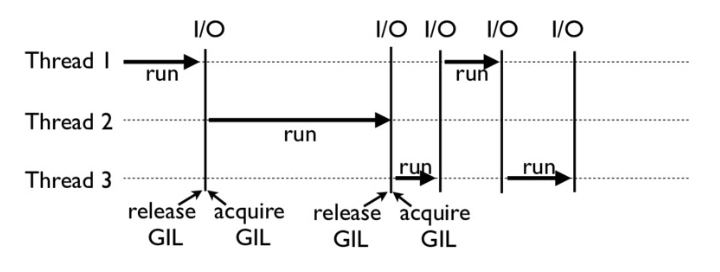

CPython 中还有另一个机制，叫做 check_interval，意思是 CPython 解释器会去轮询检查线程 GIL 的锁住情况。每隔一段时间，Python 解释器就会强制当前线程去释放 GIL，这样别的线程才能有执行的机会。

不同版本的 Python 中，check interval 的实现方式并不一样。早期的 Python 是 100 个 ticks，大致对应了 1000 个 bytecodes；而 Python 3 以后，interval 是 15 毫秒。

In [55]:
import threading

n = 0

def foo():
    global n
    n += 1

threads = []
for i in range(100):
    t = threading.Thread(target=foo)
    threads.append(t)

for t in threads:
    t.start()

for t in threads:
    t.join()

print(n)


100


如果你执行的话，就会发现，尽管大部分时候它能够打印 100，但有时侯也会打印 99 或者 98。

这其实就是因为，n+=1这一句代码让线程并不安全。如果你去翻译 foo 这个函数的 bytecode，就会发现，它实际上由下面四行 bytecode 组成：
```python
import dis 
dis.dis(foo) 

LOAD_GLOBAL 0 (n) 
LOAD_CONST 1 (1) 
INPLACE_ADD 
STORE_GLOBAL 0 (n)
```

而这四行 bytecode 中间都是有可能被打断的！ 

所以，千万别想着，有了 GIL 你的程序就可以高枕无忧了，我们仍然需要去注意线程安全。正如我开头所说，GIL 的设计，主要是为了方便 CPython 解释器层面的编写者，而不是 Python 应用层面的程序员。**作为 Python 的使用者，我们还是需要 lock 等工具，来确保线程安全**。比如我下面的这个例子：

In [57]:
# 添加线程锁
n = 0
lock = threading.Lock()

def foo():
    global n
    with lock:
        n += 1


threads = []
for i in range(100):
    t = threading.Thread(target=foo)
    threads.append(t)

for t in threads:
    t.start()

for t in threads:
    t.join()

print(n)

100


## 如何绕过 GIL

Python 的 GIL，是通过 CPython 的解释器加的限制。如果你的代码并不需要 CPython 解释器来执行，就不再受 GIL 的限制。

事实上，很多高性能应用场景都已经有大量的 C 实现的 Python 库，例如 NumPy 的矩阵运算，就都是通过 C 来实现的，并不受 GIL 影响。

所以，大部分应用情况下，你并不需要过多考虑 GIL。因为如果多线程计算成为性能瓶颈，往往已经有 Python 库来解决这个问题了。

总的来说，你只需要重点记住，绕过 GIL 的大致思路有这么两种就够了： 
1. 绕过 CPython，使用 JPython（Java 实现的 Python 解释器）等别的实现； 
2. 把关键性能代码，放到别的语言（一般是 C++）中实现。


# 思考题 

在我们处理 cpu-bound 的任务（文中第一个例子）时，为什么有时候使用多线程会比单线程还要慢些？ 

cpu-bound属于计算密集型程序，用多线程运行时，每个线程在开始执行时都会锁住GIL、执行完会释放GIL，这两个步骤比较费时。相比单线程就没有切换线程的问题，所以更快。

相反，在处理多阻塞高延迟的IO密集型程序时，因为多线程有check interval机制，若遇阻塞，CPython会强制当前线程让出（释放）GIL，给其他线程执行的机会。所以能提高程序的执行效率。

### 啥是Python解释器

Python解释器是Python程序运行的核心，它负责读取Python代码并将其转换为机器语言，从而使计算机能够执行。简单来说，Python解释器就像是Python代码与计算机之间的翻译官，把Python代码翻译成计算机能懂的语言。

Python解释器的主要作用有以下几点：

1. 代码翻译：将Python代码翻译成计算机能理解的机器语言。
2. 动态执行：解释器可以实时执行Python代码，无需先编译成二进制文件。
3. 错误检查：在代码执行过程中，解释器会检查语法错误和运行时错误，并给出相应的错误信息。

通过Python解释器，我们可以方便地编写和运行Python程序，实现各种功能。

使用Python解释器非常简单，只需在命令行中输入python命令即可启动解释器。下面是一个简单的示例：
```txt
# 打开命令行终端
$ python
Python 3.x.x (default, ...) 
[GCC ...] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> 
```
在>>>提示符下，你可以输入Python代码并立即看到执行结果。

你也可以直接运行一个Python脚本文件，只需在命令行中指定脚本文件的路径即可：`$ python my_script.py`


**Python解释器的种类与选择**:

Python解释器有多种实现方式，其中最常见的是CPython。CPython是用C语言编写的Python解释器，也是官方推荐的解释器。除此之外，还有Jython（Java实现）、IronPython（.NET实现）等其他实现方式。




In [63]:
# test dis package

import dis
def test():
    print('hello')
    
test()

dis.dis(test)

hello
  4           0 RESUME                   0

  5           2 LOAD_GLOBAL              1 (NULL + print)
             14 LOAD_CONST               1 ('hello')
             16 PRECALL                  1
             20 CALL                     1
             30 POP_TOP
             32 LOAD_CONST               0 (None)
             34 RETURN_VALUE


1. LOAD_GLOBAL 0：告诉 Python 在全局对象引用名称元组 co_names 中取出索引为 0 的元素，即 print，然后将它推入到计算栈。
2. LOAD_CONST 1：在常量元组 co_consts 中取出索引为 1 的元素，即 ‘hello!’ ，并将它推入栈。索引为 0 的元素是 None，这是因为 Python 中 return 语句默认情况下返回 None，当我们不写 return 语句时，默认就是返回这个索引为 0 的 None。
3. PRECALL 1： 函数‘hello'准备被调用。
4. CALL 1：Python 去调用一个函数；它需要从栈中弹出一个位置参数，然后，新的栈顶将被函数调用。
5. POP_TOP：删除栈顶部，这里说明 print 函数使用完毕，返回 hello 函数。
6. LOAD_CONST 0：这里取出常量 None，因为 test 没有写 return，默认返回 None。None 在索引为 0 的位置。
7. RETURN_VALUE：返回值，函数调用结束。